In [1]:
from utils.load_dataset import *
from utils.custom_utils import *

In [2]:
train_df = load_training(target_txt)
test_df = load_testing(test_txt)

In [3]:
images_ids = train_df['img_path'].unique()

split_len = round(len(images_ids)*0.8) #80% -> train & 20% -> val

train_ids = images_ids[:split_len]
valid_ids = images_ids[split_len:]

train = train_df[train_df['img_path'].isin(train_ids)]
valid = train_df[train_df['img_path'].isin(valid_ids)]

In [4]:
labels = list(train['label'].values)
class_counts = train['label'].value_counts().tolist()
num_samples = len(labels)
class_weights = [class_counts[1]/class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[0] if l == 1 else class_weights[1] for l in labels]
train['weights'] = weights
train_grouped = train.groupby(['img_path']).mean()
weights = list(train_grouped['weights'].values)
print(len(weights))

4857


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [5]:
train_dataset = FallenPeople(train, DATASET, FallenPeople.train_transform())
valid_dataset = FallenPeople(valid, DATASET, FallenPeople.valid_test_transform())
test_dataset = FallenPeople(test_df, TESTING, FallenPeople.valid_test_transform())

Some images used during training...


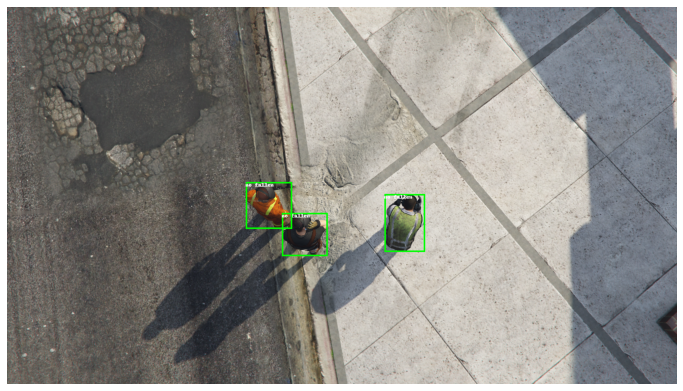

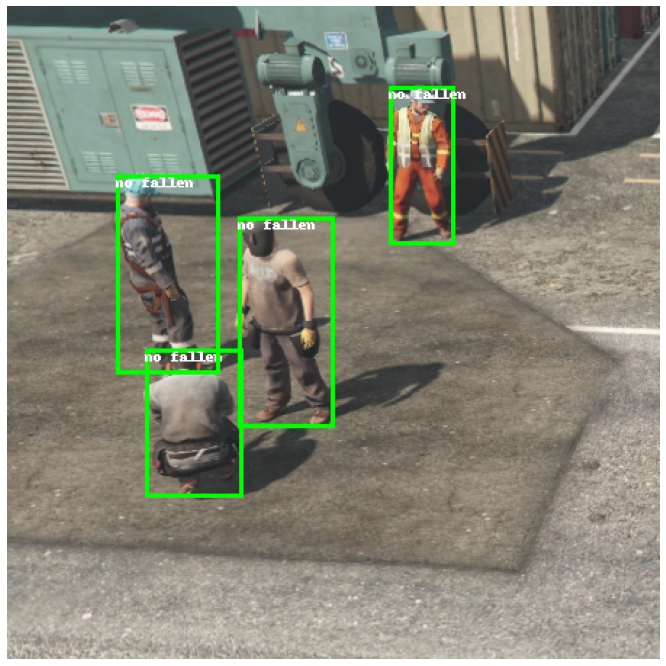

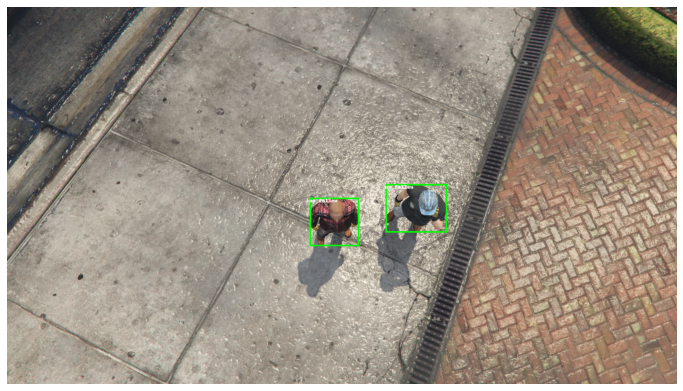

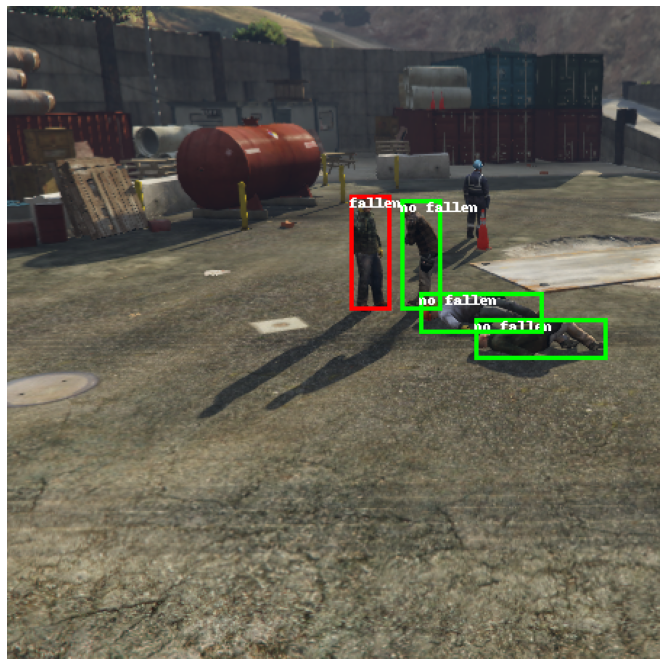

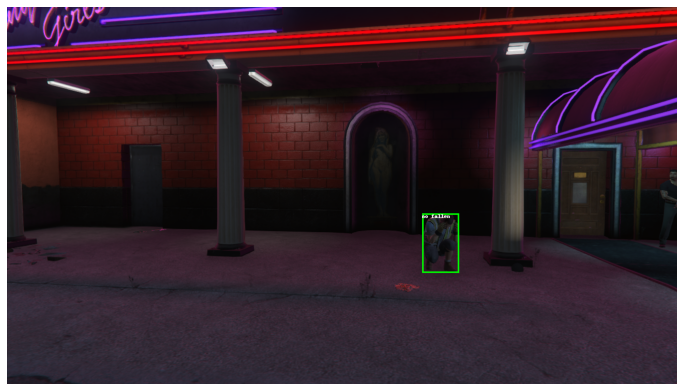

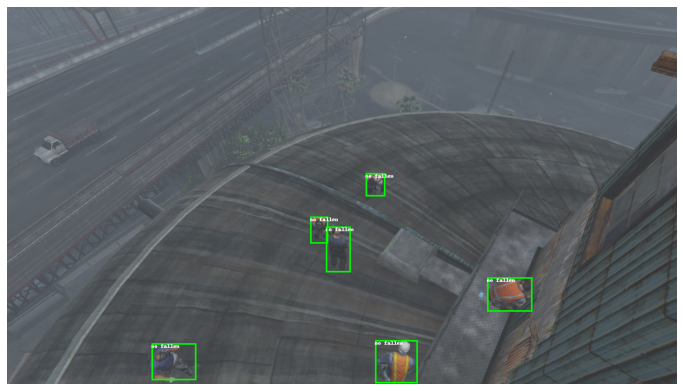

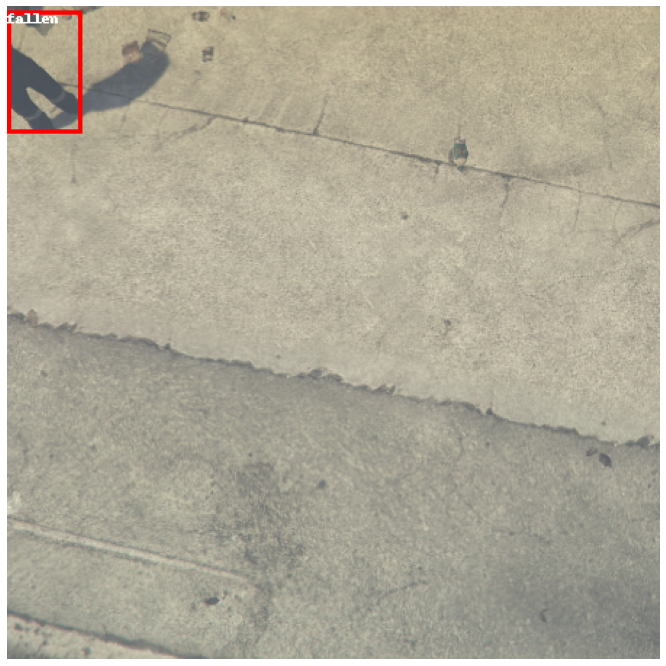

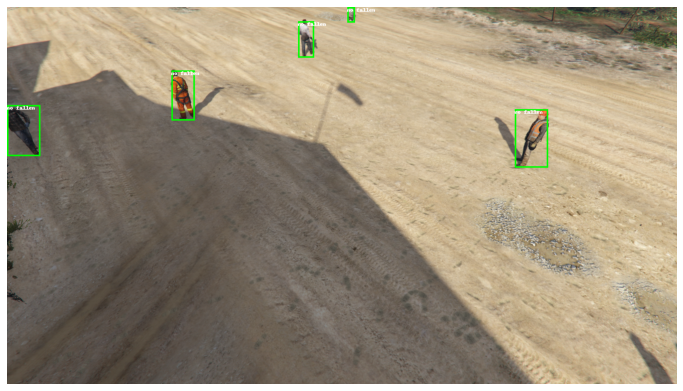

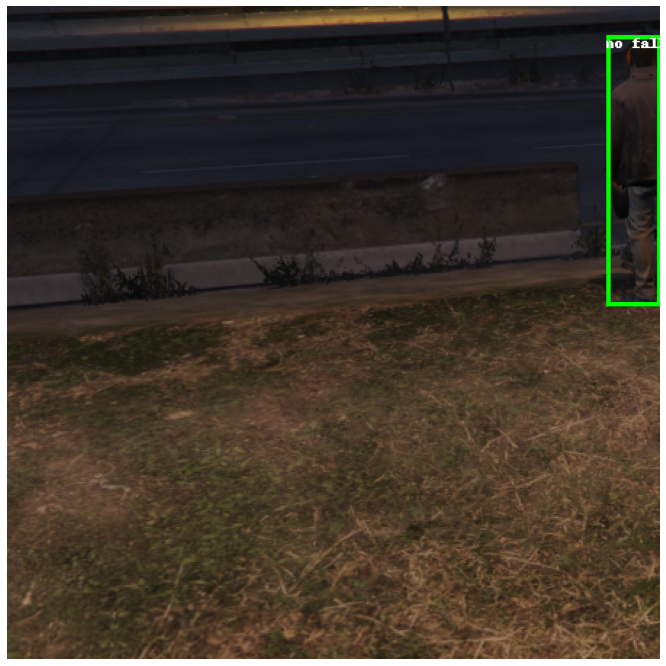

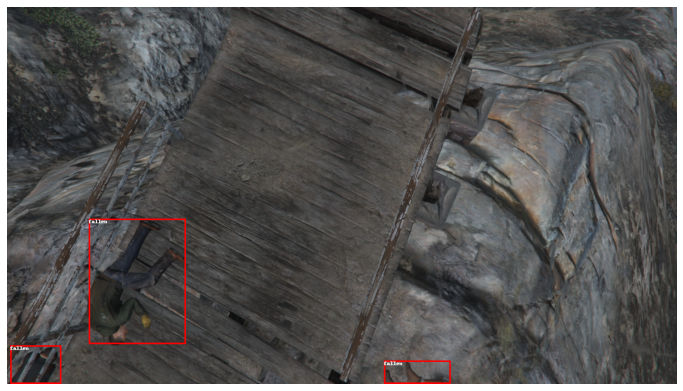

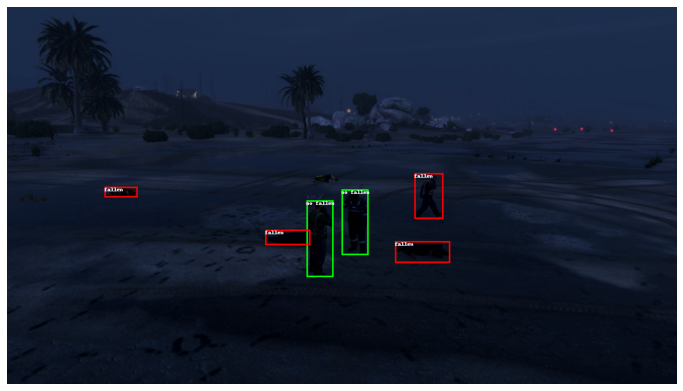

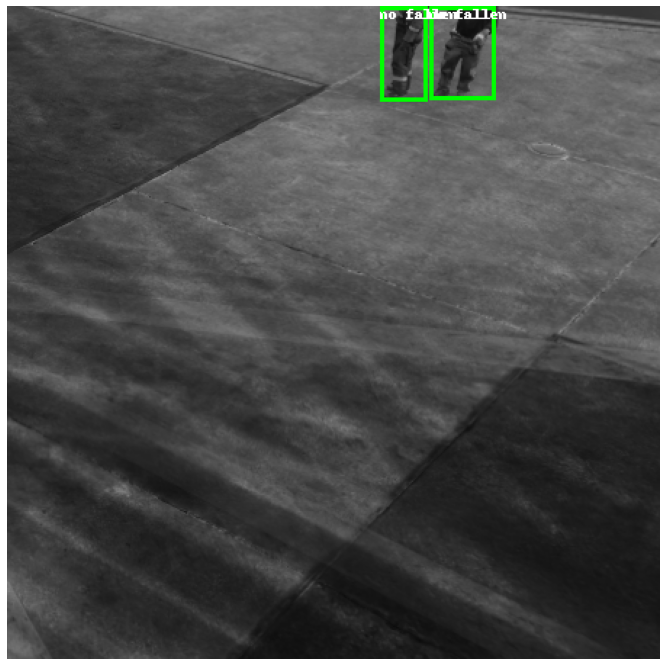

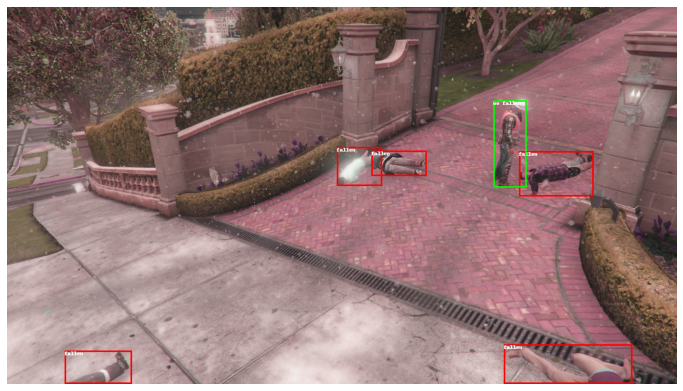

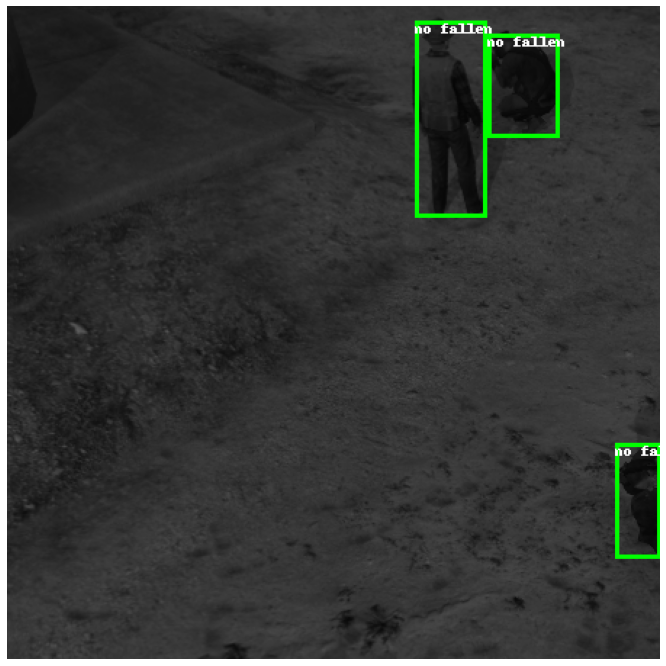

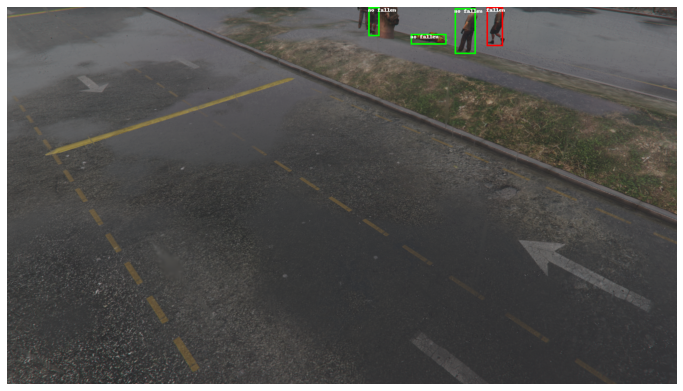

In [6]:
print("Some images used during training...")
random_list_fp = [random.randint(0,len(train_dataset)) for i in range(15)]

visualize_from_tensor_and_bb(train_dataset, random_list_fp)    

In [7]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [8]:
print(model.roi_heads.box_predictor)

num_classes = 3 # fall or no fall or not(background)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained model's head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

print(model.roi_heads.box_predictor)

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=91, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
)
FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=3, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=12, bias=True)
)


In [9]:
def collate_fn(batch):
  return tuple(zip(*batch))

sampler = torch.utils.data.WeightedRandomSampler(torch.DoubleTensor(weights), int(len(weights)))

train_data_loader = DataLoader(
  train_dataset,
  batch_size=4,
  #shuffle=False,
  collate_fn=collate_fn,
  sampler = sampler
)

valid_data_loader = DataLoader(
  valid_dataset,
  batch_size=4,
  shuffle=False,
  collate_fn=collate_fn
)

test_data_loader = DataLoader(
  test_dataset,
  batch_size=4,
  shuffle=False,
  collate_fn=collate_fn
)

In [10]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
#***************
# move model to the right device
model.to(device)

# create an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# create a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
#lr_scheduler = None

# train it for 10 epochs
num_epochs = 10

In [14]:
log_txt = filename("txt","log_file_")

In [35]:
itr = 1

total_train_loss = []
total_valid_loss = []

losses_value = 0.0

f_log = open(log_txt, "w")
for epoch in range(num_epochs):

  start_time = time.time()

  # train ------------------------------
  running_corrects = 0

  model.train()
  train_loss = []
  pbar = tqdm(train_data_loader, desc='let\'s train')
    
  for images, targets in pbar:    

    images = list(image.to(device) for image in images)

    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())

    losses_value = losses.item()
    train_loss.append(losses_value)   

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
    if itr % 10:
        f_log.write(f"Epoch: {epoch+1}, Batch: {itr}, Loss: {losses_value}\n")
    pbar.set_description(f"Epoch: {epoch+1}, Batch: {itr}, Loss: {losses_value}")
    itr += 1
    
  epoch_train_loss = np.mean(train_loss)
  total_train_loss.append(epoch_train_loss)

  # update the learning rate
  if lr_scheduler is not None:
    lr_scheduler.step()
    
  #new valid
  sys.stdout = f_log
  evaluate(model, valid_data_loader, device=device)
  sys.stdout = original_stdout
  # valid -------------------------------------

  with torch.no_grad():
    valid_loss = []
    
    for images, targets in valid_data_loader:
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
      loss_dict = model(images, targets)
      losses = sum(loss for loss in loss_dict.values())
      loss_value = losses.item()
      valid_loss.append(loss_value)
    
  epoch_valid_loss = np.mean(valid_loss)
  total_valid_loss.append(epoch_valid_loss)  

  # print losses ------------------------------
  f_log.write("\nVALIDATION PHASE... ")
  print("\nVALIDATION PHASE... ")
  f_log.write(f"Epoch Completed: {epoch+1}/{num_epochs}, Time: {time.time()-start_time}, "
        f"Train Loss: {epoch_train_loss}, Valid Loss: {epoch_valid_loss}\n")  
  print(f"Epoch Completed: {epoch+1}/{num_epochs}, Time: {time.time()-start_time}, "
        f"Train Loss: {epoch_train_loss}, Valid Loss: {epoch_valid_loss}")

  #testing --------------------------------------
  f_log.write("\nTESTING PHASE: ")  
  print("\nTESTING PHASE... ")
  sys.stdout = f_log
  evaluate(model, test_data_loader, device=device)
  sys.stdout = original_stdout
f_log.close()

let's train:   0%|          | 0/1215 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]



TESTING PHASE... 


let's train:   0%|          | 0/1215 [00:00<?, ?it/s]


TESTING PHASE... 


let's train:   0%|          | 0/1215 [00:00<?, ?it/s]


TESTING PHASE... 


let's train:   0%|          | 0/1215 [00:00<?, ?it/s]


TESTING PHASE... 


let's train:   0%|          | 0/1215 [00:00<?, ?it/s]


TESTING PHASE... 


let's train:   0%|          | 0/1215 [00:00<?, ?it/s]


TESTING PHASE... 


let's train:   0%|          | 0/1215 [00:00<?, ?it/s]


TESTING PHASE... 


let's train:   0%|          | 0/1215 [00:00<?, ?it/s]


TESTING PHASE... 


let's train:   0%|          | 0/1215 [00:00<?, ?it/s]


TESTING PHASE... 


let's train:   0%|          | 0/1215 [00:00<?, ?it/s]


TESTING PHASE... 


In [27]:
!nvidia-smi

Mon Nov 29 10:44:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    On   | 00000000:03:00.0 Off |                  N/A |
| 37%   45C    P8    11W / 180W |   3701MiB /  8117MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    On   | 00000000:04:00.0 Off |                  N/A |
| 27%   44C    P2    40W / 180W |    963MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

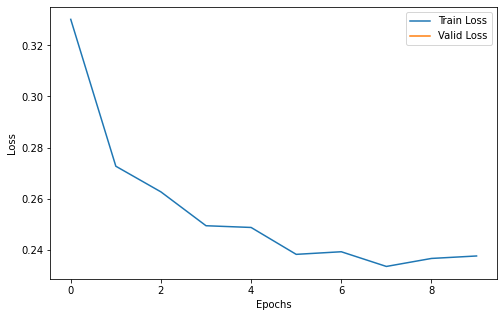

In [36]:
plt.figure(figsize=(8, 5))
plt.plot(total_train_loss, label="Train Loss")
plt.plot(total_valid_loss, label="Valid Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [55]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fallen_people_v1_2911_balanced_dataset_augmentation.pth')